# Helper Functions

## Imports

In [ ]:
import boto3
import json
import pytz
import time
from tqdm import tqdm
import seaborn as sea
import requests 
import mplfinance as mpf
import pandas as pd
from zoneinfo import ZoneInfo
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## Credentials and dates

In [15]:
def get_secret():
    client = boto3.client('secretsmanager', region_name='us-west-2')
    return json.loads(client.get_secret_value(SecretId="tokens")['SecretString'])

def parse_time(iso_string ):
    utc_time = datetime.fromisoformat(iso_string.replace("Z", "+00:00"))
    portland_time = utc_time.astimezone(ZoneInfo("America/Los_Angeles"))
    return portland_time

secret = get_secret()
alpaca_key = secret['alpaca_key']
alpaca_secret = secret['alpaca_secret']
polygon_key = secret['polygon_key']

## Plotting

In [16]:
def plot_candles(data):
    df = pd.DataFrame(data)
    df['t'] = pd.to_datetime(df['t'])  # Convert timestamp to pandas datetime
    df.set_index('t', inplace=True)  # Set datetime as index
    df = df.rename(columns={'ha_o': 'Open', 'ha_h': 'High', 'ha_l': 'Low', 'ha_c': 'Close'})  # Rename for mplfinance
    
    # Plot using mplfinance
    mpf.plot(df, type='candle', style='charles', title='Heikin-Ashi Chart', ylabel='Price')
    return 

## Heikin Ashi

In [17]:
def calculate_heikin_ashi(data):

    heikin_ashi = []
    previous_ha_close = (data[0]['o'] + data[0]['h'] + data[0]['l'] + data[0]['c']) / 4
    previous_ha_open = (data[0]['o'] + data[0]['c']) / 2

    for candle in data:
        ha_close = (candle['o'] + candle['h'] + candle['l'] + candle['c']) / 4
        ha_open = (previous_ha_open + previous_ha_close) / 2
        ha_high = max(candle['h'], ha_open, ha_close)
        ha_low = min(candle['l'], ha_open, ha_close)
        heikin_ashi.append({
            't': candle['t'],
            'ha_o': ha_open,
            'ha_h': ha_high,
            'ha_l': ha_low,
            'ha_c': ha_close
        })

        previous_ha_open = ha_open
        previous_ha_close = ha_close

    return heikin_ashi

## Getting Data

### Candles

In [18]:
def get_candles(ticker, start_date, end_date, timeframe = '30Min'):
    base_url = "https://data.alpaca.markets/v2/stocks"
    headers = {
        "APCA-API-KEY-ID": alpaca_key,
        "APCA-API-SECRET-KEY": alpaca_secret
    }
    
    # Parse the start and end dates
    start_time = pd.to_datetime(start_date)
    end_time = pd.to_datetime(end_date)
    today = datetime.today()  # Use UTC to match API expectations

    # Ensure the end date is not in the future
    if end_time > today:
        raise ValueError("end_date cannot be in the future.")

    params = {
        "start": start_time.isoformat() + "Z",  # Format as ISO 8601
        "end": end_time.isoformat() + "Z",     # Format as ISO 8601
        "timeframe": timeframe  # Adjust timeframe as needed (e.g., "1Min", "5Min", "1Day")
    }

    url = f"{base_url}/{ticker}/bars"
    r = requests.get(url, headers=headers, params=params)
    
    if r.status_code == 200:
        data = r.json().get('bars', [])
        for row in data:
            row['t'] = parse_time(row['t'])

        # Define trading hours in UTC
        trading_start = datetime.strptime("09:30", "%H:%M").replace(tzinfo=pytz.timezone("US/Eastern"))
        trading_end = datetime.strptime("16:00", "%H:%M").replace(tzinfo=pytz.timezone("US/Eastern"))

        # Filter for only regular trading hours
        filtered_data = []
        for row in data:
            candle_time = row['t'].astimezone(pytz.timezone("US/Eastern"))
            if trading_start.time() <= candle_time.time() <= trading_end.time():
                filtered_data.append(row)

        return filtered_data
    else:
        r.raise_for_status()


### Dividend Dates

In [27]:
def get_dividend_dates(ticker):
    url = f"https://api.polygon.io/v3/reference/dividends?ticker={ticker}&apiKey={polygon_key}"
    results = []
    
    while url:
        if 'apiKey' not in url:
            url = url + f'&apiKey={polygon_key}'
        r = requests.get(url)
        
        if r.status_code != 200:
            raise Exception(f"Failed to fetch data: {r.status_code} - {r.text}")
        
        data = r.json()
        results.extend(data.get('results', []))
        
        url = data.get('next_url')
        time.sleep(12)
    
    return results

### One Day Profitability (Uses Candles)

# Analysis

In [ ]:
ticker = 'SGA'
divs = get_dividend_dates(ticker)

In [ ]:
from tqdm import tqdm

## Exit Day Trend

### Helper Funcs

In [29]:

def analyze(row):
    ex_div_date = pd.to_datetime(row['ex_dividend_date'])
    candles = pd.DataFrame(row['candles'])
    candles['t'] = pd.to_datetime(candles['t'])
    candles['date'] = candles['t'].dt.date
    candles = candles.groupby('date')[['vw']].mean()
    candles = candles.reset_index()
    candles['div_date'] = pd.to_datetime(candles['date']) == pd.to_datetime(ex_div_date)
    candles['time'] = candles.index - candles['div_date'].idxmax()
    candles = candles.set_index('time')
    return candles

### Charts

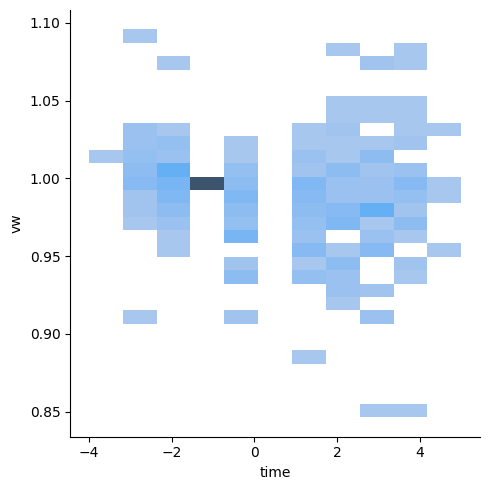

<Axes: xlabel='time', ylabel='vw'>

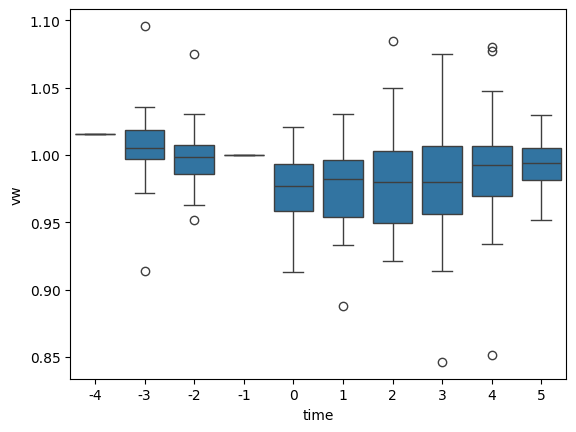

In [30]:
final = []
for row in divs: 
    ex_div_date = row['ex_dividend_date']
    record_date = row['record_date']

    begin = pd.to_datetime(record_date) - pd.offsets.BDay(4)
    end = pd.to_datetime(record_date) + pd.offsets.BDay(4)
    try:
        candles = get_candles(ticker, begin, end, '1Hour')
        row['candles'] = candles
        final.append(row)
    except Exception as e:
        pass
results = []
for thing in final: 
    ans = analyze(thing)
    base_price = ans.loc[-1]['vw']
    ans['vw'] = ans['vw']/base_price
    ans['date'] = thing['record_date']
    results.append(ans)

x = pd.concat(results).reset_index()
sea.displot(x = x['time'],y = x['vw'])
plt.show()
sea.boxplot(x = x['time'], y = x['vw'])